In [1]:
import cv2 as cv
import numpy as np
import math
from numpy.lib.function_base import disp
def obj_recog():
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
    !fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
    # jupyter调用摄像头的代码
    im = cv.imread(orig_img_path)
    #cv.imshow('t',im)
    #cv.imgshow(im)
    width = im.shape[1]
    height = im.shape[0]
    rate = round(width*0.5)
    rate1 = round(height*0.2)
    half = round(height/2)
    ims = im[rate1:half,0:(width-rate)]
    ims_right = im[(half+1):(height-rate1),0:(width-rate)]
    lower_red = np.array([0, 43, 20]) # 红色范围低阈值
    upper_red = np.array([20, 255, 255]) # 红色范围高阈值
    lower_red2 = np.array([150, 43, 20]) # 红色范围低阈值
    upper_red2 = np.array([200, 255, 255]) # 红色范围高阈值
    hsv_img = cv.cvtColor(ims, cv.COLOR_BGR2HSV)
    mask_red = cv.inRange(hsv_img, lower_red, upper_red)
    mask_red2 = cv.inRange(hsv_img, lower_red2, upper_red2)
    mask = cv.bitwise_or(mask_red,mask_red2)
    # again for right side
    hsv_img_right = cv.cvtColor(ims_right, cv.COLOR_BGR2HSV)
    mask_red_right = cv.inRange(hsv_img_right, lower_red, upper_red)
    mask_red_right2 = cv.inRange(hsv_img_right, lower_red2, upper_red2)
    mask_right = cv.bitwise_or(mask_red_right,mask_red_right2)
    
    #print(mask_red)
    #print(mask_red2)
    #print(mask)
    #print(np.sum(mask_red))
    #print(np.sum(mask_red2))
    #print(np.sum(mask))
    nl = np.sum(mask)
    nr = np.sum(mask_right)
    #print(number)
    number = nl + nr
    
    h1 = height - rate1*2
    w1 = width - rate
    S = h1*w1
    print("nr",nr/255)
    print("nl",nl/255)
    test = nr/255 - nl/255
    print(test )
    print(number/S/255)
    number = (number/S/255)
    
    yu = 2000
    
    if(number < 0.01):
        kind =  0
    else:
        kind = 1
    #if (number>0.01 && number<0.03 && number>0.5):
        #kind = 

    return kind

def takepic():
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
    !fswebcam  --no-banner --save {orig_img_path} -d /dev/video2 2

In [2]:
import binascii
import serial
import os
os.system('sh ./stop_sys_ttyPS0.sh')
def run_action(cmd):
    ser = serial.Serial("/dev/ttyPS0", 9600, timeout=5)
    cnt_err = 0
    while 1:
        test_read = ser.read()
        print('test_read', test_read)
        cnt_err += 1
        if test_read== b'\xa3' or cnt_err == 50:
            break
    
    if cnt_err == 50:
        print('can not get REQ')
    else:
        print('read REQ finished!')
        ser.write(cmd2data(cmd))
        print('send action ok!')
    ser.close()
    
def crc_calculate(package):
    crc = 0
    for hex_data in package:

        b2 = hex_data.to_bytes(1, byteorder='little')
        crc = binascii.crc_hqx(b2, crc)

    return [(crc >> 8), (crc & 255)]    # 校验位两位

def cmd2data(cmd):
    cnt=0
    cmd_list=[]
    for i in cmd:
        cnt+=1
        cmd_list+=[ord(i)]
    cmd_list=[0xff,0xff]+[(cnt+5)>>8,(cnt+5)&255]+[0x01,(cnt+1)&255,0x03]+cmd_list
    cmd_list=cmd_list+crc_calculate(cmd_list)
    return cmd_list

def wait_req():
    ser = serial.Serial("/dev/ttyPS0", 9600, timeout=5)
    while 1:
        test_read=ser.read()
        if test_read== b'\xa3' :
            print('read REQ finished!') 
            break

In [3]:
def getpos(): # get an integer
    # get quarter aa bb cc
    # assume
    #(a1 a2)b1 b2,c1,c2
    #input : n1,n2
    m = (b2-a2)/(b1-a1)
    theta = math.atan(m)
    n1 = n1-a1
    n2 = n2-a2
    #define matrix
    #m1 m2
    #m3 m4
    pi = math.pi
    m1 = math.cos(pi - theta)
    m2 = -math.sin(pi - theta)
    #m3 = m1
    #m4 = -m2
    k1 = n1*m1 - n2*m1
    k2 = n1*m2 + n2*m1
    k1 = math.floor(k1/3)
    k2 = math.floor(k2/9)
    out = 3*k2+ k1
    return out

def center():
    ff = 0
    lrmin= 250 #######TODO
    rrmin=250  #######TODO
    mk_min = 10
    rmax = 100   #######TODO
    mrmax = 250
    mrmin = 150
    while(ff==0):
        takepic()
        img = cv.imread('/home/xilinx/jupyter_notebooks/common/data/webcam.jpg')
        [lk,lr,mk,mr,rk,rr] = houfline(img)
        if(mk==0):
            run_action('Back2Run')
            wait_req()
            print('back because mk==0')
            run_action('Stand')
            wait_req()
        elif(abs(mk)<mk_min):
            if(mk>0):
                #left
                run_action('turn001L')
                wait_req()
            elif(mk<0):    
                run_action('turn001R')
                wait_req()
        elif(mr<mrmin):
            run_action('Back2Run')
            #run_action('fastForward03')
            wait_req()
            print('back because too close')
            run_action('Stand')
            wait_req()
        elif(mr>mrmax):
            run_action('Forwalk02')########TODO
            #run_action('fastForward03')
            wait_req()
        elif(lk!=0 and rk!=0):
            if(abs(lr-rr)>rmax):
                if(lr>rr):
                    run_action('Left3move')
                    wait_req()
                elif(lr<rr):
                    run_action('Right3move')
                    wait_req()
            else:
                ff = 1        
        elif(lk==0 or rk == 0):
            if(lk!=0):
                if(lr<lrmin):
                    run_action('Right3move')
                    wait_req()    
            elif(rr!=0):
                if(rr<rrmin):
                     run_action('Left3move')
                     wait_req()    
def houfline_black(img):
    img = img[:,50:370]
    cv.imshow("img1",img)
    #hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    l_black = np.array([[0,0,0]])
    h_black = np.array([[50,100,50]])
    mask = cv.inRange(img, l_black, h_black)
    cv.imshow("mas",mask)
    edges = cv.Canny(mask,50,150,apertureSize = 3)
    cv.imshow("mask", edges)
    cv.waitKey(0)
    cv.destroyAllWindows()
    #lines = cv.HoughLinesP(mask_g,1,np.pi/180,100,minLineLength=100,maxLineGap=1)
    lines = cv.HoughLinesP(edges,1,np.pi/180,70,minLineLength=10,maxLineGap=100)
    x1,y1,x2,y2 = lines[0][0]
    # if lines is None:
    #     return 0,0,0
    # for line in lines:
    #     x1,y1,x2,y2 = line[0]
    #     cv.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    m = (y1-y2)/(x1-x2)
    p = [0,240]
    a = y1-y2
    b = x2-x1
    c = x1*y2 - y1*x2
    dis = abs(a*p[0]+b*p[1]+c)/math.sqrt(a*a+b*b)
    return [m,dis]
def houfline(img):
    img = img[:,50:370]
    # cv.imshow("img",img)
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    l_blue = np.array([[100,43,46]])
    h_blue = np.array([[124,255,255]])
    l_green = np.array([[40,100,100]])
    h_green = np.array([[60,200,255]])
    mask_b = cv.inRange(hsv, l_blue, h_blue)
    mask_g = cv.inRange(hsv, l_green, h_green)
    res = cv.bitwise_or(mask_b, mask_g)
    # cv.imshow("test", res)
    # cv.imshow("mask", mask_g)
    list1 = []
    edges = cv.Canny(res,50,150,apertureSize = 3)
    # cv.imshow("mask2", edges)
    #lines = cv.HoughLinesP(mask_g,1,np.pi/180,100,minLineLength=100,maxLineGap=1)
    lines = cv.HoughLinesP(edges,1,np.pi/180,70,minLineLength=10,maxLineGap=100)
    print(lines)
    if lines is None:
        return 0,0,0
    for line in lines:
        x1,y1,x2,y2 = line[0]
        #print(x1,y1,x2,y2)
        m = (y1-y2)/(x1-x2)
        p = [0,240]
        a = y1-y2
        b = x2-x1
        c = x1*y2 - y1*x2
        dis = abs(a*p[0]+b*p[1]+c)/math.sqrt(a*a+b*b)
        #print(dis,m)
        
        flag = 0
        if (len(list1) == 0) :
            if(math.isinf(m)):
                break
            list1.append([m,dis])
        else:
            for i in range(0,len(list1)):
                if ( abs(math.atan(m)-math.atan(list1[i][0])) < 0.5 and abs(dis-list1[i][1])<200):
                    # list1[i][0] = (m+list1[i][0])/2
                    # list1[i][1] = (list1[i][1]+dis)/2
                    flag = 1
                    break
                elif(math.isinf(m)):
                    flag = 1
                    break
                    
            if (flag == 0):               
                list1.append([m,dis])
                     
            
        # cv.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    #cv.imwrite('houghlines3.jpg',img)
    
    # cv.imshow("img",img)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    #shape (640,480 3)
    print(list1)
    print(len(list1))

    nn = len(list1)
    mk = 0
    mr = 0
    lk = 0
    lr = 0
    rk = 0
    rr = 0
    kmax = 1.2
    kmin = -1
    mlmax = 300 #######TODO
    mr_big = 999
    for i in range(0,nn):
        if(abs(list1[i][0])>kmax and list1[i][1] < mr_big):
            mk = list1[i][0]
            mr = list1[i][1]
            mr_big = mr
        if(list1[i][0]<kmax and list1[i][0]>0):
            lk = list1[i][0]
            lr = list1[i][1]
        if(list1[i][0] > kmin and list1[i][0]<0):
            rk = list1[i][0]
            rr = list1[i][1]  
    print("all",[lk,lr,mk,mr,rk,rr])        
    return [lk,lr,mk,mr,rk,rr]


# des = 
# anti =
def halfrun():
    print("Start Halfrun!!!")
    dis_left = 200
    k_left = 0.5
    dis_right=200
    k_right = -0.5
    mk_min = 10
    rmax = 10
    for i in range(1,5):
        run_action('fastForward03')
        wait_req()
        center()

In [4]:
import binascii
import serial
import os
os.system('sh ./stop_sys_ttyPS0.sh')
def run_action(cmd):
    ser = serial.Serial("/dev/ttyPS0", 9600, timeout=5)
    cnt_err = 0
    while 1:
        test_read = ser.read()
        #print('test_read', test_read)
        cnt_err += 1
        if test_read== b'\xa3' or cnt_err == 50:
            break
    if cnt_err == 50:
        print('can not get REQ')
    else:
        #print('read REQ finished!')
        ser.write(cmd2data(cmd))
        #print('send action ok!')
    ser.close()
    
def crc_calculate(package):
    crc = 0
    for hex_data in package:

        b2 = hex_data.to_bytes(1, byteorder='little')
        crc = binascii.crc_hqx(b2, crc)

    return [(crc >> 8), (crc & 255)]    # 校验位两位

def cmd2data(cmd):
    cnt=0
    cmd_list=[]
    for i in cmd:
        cnt+=1
        cmd_list+=[ord(i)]
    cmd_list=[0xff,0xff]+[(cnt+5)>>8,(cnt+5)&255]+[0x01,(cnt+1)&255,0x03]+cmd_list
    cmd_list=cmd_list+crc_calculate(cmd_list)
    return cmd_list

def wait_req():
    ser = serial.Serial("/dev/ttyPS0", 9600, timeout=5)
    while 1:
        test_read=ser.read()
        if test_read== b'\xa3' :
            print('read REQ finished!') 
            break

In [5]:
def lefty():
    print("Start Lefty!!!")
    for i in range(12):
        run_action('Left3move') 
        wait_req()
    kind = obj_recog()
    while(kind==1):
        run_action('Left3move')
        wait_req()
        kind = obj_recog()
    #center() 

def righty():
    print("Start Righty!!!")
    for i in range(12):
        run_action('Right3move')
        wait_req()       
    kind = obj_recog()
    while(kind==1):
        run_action('Right3move')
        wait_req()
        kind = obj_recog()
    #center()

In [72]:
# des = 1, 2            anti = 1,2,3,4
des = 2
anti = 4

if( des== 1 and anti == 1):
    # right forward2
    righty()
    #
    halfrun()
    halfrun()
    #
    wait_req()

elif(des== 1 and anti == 2):
    # you qian1 zuo qian1 you
    # right forward2
    righty()
    #
    #
    halfrun()
    lefty()

    halfrun()
    #
    righty()
    wait_req()

elif(des== 1 and anti == 3):
    # qian you qian
    halfrun()
    righty()
    halfrun()

elif(des== 1 and anti == 4):
    # qian2 you
    halfrun()
    halfrun()
    righty()
elif(des== 2 and anti == 1):
    # qian2 zuo
    halfrun()
    halfrun()
    lefty()
elif(des== 2 and anti == 2):
    # qian zuo qian
    halfrun()
    lefty()
    halfrun()

elif(des== 2 and anti == 3):
    # zuo qian you qian zuo 
    lefty()
    halfrun()
    righty()
    halfrun()
    lefty()

elif(des== 2 and anti == 4):
    # zuo qian
    lefty()
    halfrun()
    halfrun()

Start Lefty!!!
read REQ finished!
read REQ finished!


KeyboardInterrupt: 

In [80]:
center()

--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
[[[ 53   0  94 390]]

 [[ 79 470 210 381]]

 [[ 77 267  77  73]]

 [[ 53 202  55 342]]

 [[ 69  93  73 293]]

 [[ 50 459 212 370]]]
[[9.5121951219512191, 77.802019001996953], [-0.67938931297709926, 234.64230191442368]]
2
all [0, 0, 9.5121951219512191, 77.802019001996953, -0.67938931297709926, 234.64230191442368]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in int_scalars


read REQ finished!
--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
[[[ 98  31 201  90]]

 [[ 27 382  31 356]]]
[[0.57281553398058249, 230.0648658800821], [-6.5, 48.278156000626304]]
2
all [0.57281553398058249, 230.0648658800821, -6.5, 48.278156000626304, 0, 0]
read REQ finished!
--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
[[[ 80   7 177  58

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.


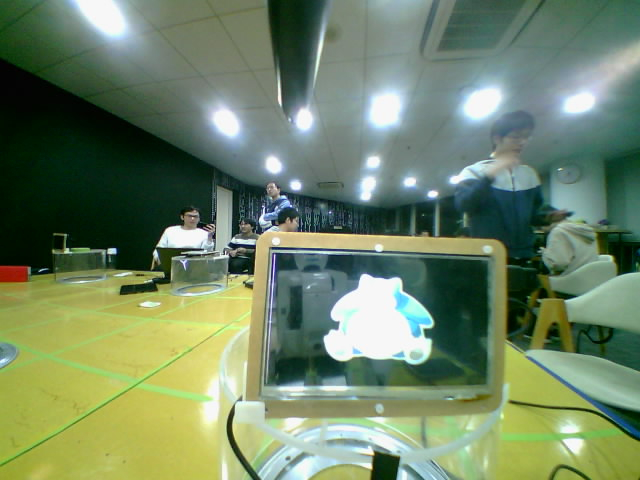

In [87]:
from PIL import Image
orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
!fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
img = Image.open(orig_img_path)
img

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.


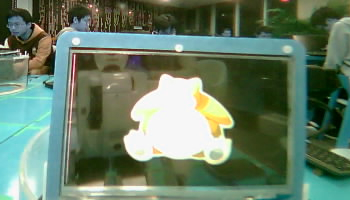

In [101]:
from PIL import Image
orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
!fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
img = cv.imread(orig_img_path)
img = img[200:400,200:550,:]
img2=Image.fromarray(img)
img2

In [62]:
run_action("Wanyao20")
wait_req()
run_action("Stand")

read REQ finished!


In [44]:
takepic()
img = cv.imread('/home/xilinx/jupyter_notebooks/common/data/webcam.jpg')
[lk,lr,mk,mr,rk,rr] = houfline(img)

--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
[[-18.38095238095238, 305.22479569475331], [-19.449999999999999, 26.150549770268388], [-0.55244755244755239, 227.92330551295876], [0.77631578947368418, 301.8605388577983]]
4
all [0.77631578947368418, 301.8605388577983, -19.449999999999999, 26.150549770268388, -0.55244755244755239, 227.92330551295876]


In [6]:
def center2():
    ff = 0
    lrmin= 250 #######TODO
    rrmin=250  #######TODO
    mk_min = 10
    rmax = 100   #######TODO
    mrmax = 150
    mrmin = 0
    while(ff==0):
        takepic()
        img = cv.imread('/home/xilinx/jupyter_notebooks/common/data/webcam.jpg')
        [lk,lr,mk,mr,rk,rr] = houfline(img)
        if(mk==0):
            print('finish')
            break
            #run_action('Back2Run')
            #wait_req()
            #print('back because mk==0')
            #run_action('Stand')
            #wait_req()
        elif(abs(mk)<mk_min):
            if(mk>0):
                #left
                run_action('turn001L')
                wait_req()
            elif(mk<0):    
                run_action('turn001R')
                wait_req()
        elif(mr<mrmin):
            #run_action('Back2Run')
            #run_action('fastForward03')
            #wait_req()
            print('close enough')
            return 0
            #run_action('Stand')
            #wait_req()
        elif(mr>mrmax):
            run_action('Forwalk02')########TODO
            #run_action('fastForward03')
            wait_req()
        elif(lk!=0 and rk!=0):
            if(abs(lr-rr)>rmax):
                if(lr>rr):
                    run_action('Left3move')
                    wait_req()
                elif(lr<rr):
                    run_action('Right3move')
                    wait_req()
            else:
                ff = 1        
        elif(lk==0 or rk == 0):
            if(lk!=0):
                if(lr<lrmin):
                    run_action('Right3move')
                    wait_req()    
            elif(rr!=0):
                if(rr<rrmin):
                     run_action('Left3move')
                     wait_req()

In [8]:
center2()

--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
[[[191 447 285   3]]

 [[209 442 285   8]]

 [[  4  23 129  95]]

 [[233 252 269  30]]

 [[109  56 312 203]]

 [[155 111 292 200]]

 [[207 444 285   0]]

 [[107  55 312 204]]

 [[118  89 281 194]]

 [[241 208 270  26]]

 [[192 448 280  34]]

 [[195 451 285 385]]]
[[-4.7234042553191493, 229.73224597656019], [0.57599999999999996, 190.033847343422], [-0.73333333333333328, 285.46736853291975]]
3
all [0.57599999999999996, 190.033847343422, -4.7234042553191493, 229.73224597656019, -0.73333333333333328, 285.46736853291975]
read REQ finished!
--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input

/usr/lib/python3/dist-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in int_scalars


read REQ finished!
--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
[[[183 264 196  26]]

 [[147 453 174 147]]

 [[118  63 278 163]]

 [[ 92  75 262 165]]

 [[303 257 315  20]]

 [[312 161 319  63]]

 [[149 451 161 286]]

 [[  2   4 174  91]]

 [[ 12  39 134  96]]

 [[173 360 186 228]]

 [[133 443 249 362]]]
[[-18.307692307692307, 184.03658799508793], [0.625, 212.63557472927579], [-0.69827586206896552, 242.58304247695722]]
3
all [0.625, 212.63557472927579, -18.307692307692307, 184.03658799508793, -0.69827586206896552, 242.58304247695722]
read REQ finished!
--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the f